In [379]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [380]:
#Load the data
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
train.info()
y_train = train['Survived']
X_train = train.drop('Survived',axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [381]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [382]:
#Check if data is too skewed
y_train.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [383]:
#Not terrible, same order of magnitude 1 vs 0.

In [384]:
#Look for missing data
X_train.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [385]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [386]:
#as a percentage of total data
X_train.isnull().sum()/len(train)*100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [387]:
#>77% of Cabin column missing, drop it
X_train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)
X_train.isnull().sum()/len(train)*100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Embarked        0.224467
dtype: float64

In [448]:
#Now to age...missing 20%, so can definitely get some insights
train.corr()['Age'].sort_values()

Pclass        -0.369226
SibSp         -0.308247
Parch         -0.189119
Survived      -0.077221
PassengerId    0.036847
Fare           0.096067
Age            1.000000
Name: Age, dtype: float64

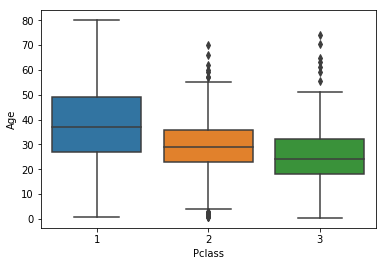

In [388]:
#Highest absolute correlation to Pclass

sns.boxplot(x='Pclass',y='Age',data=X_train)


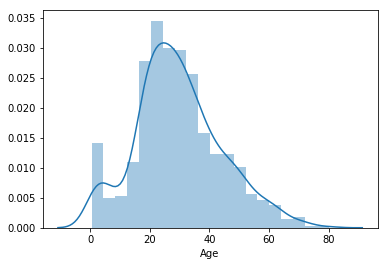

In [389]:
sns.distplot(X_train['Age'].dropna(),bins=20)

In [390]:
X_train.groupby('Pclass').mean()['Age']

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [391]:
#Let's impute age by Pclass

def get_age(df):
    if pd.isnull(df['Age']):
        return X_train.groupby('Pclass').mean()['Age'][df['Pclass']]
    else:
        return df['Age']

In [392]:
X_train['Age'] = X_train[['Age','Pclass']].apply(get_age,axis=1)
test['Age'] = test[['Age','Pclass']].apply(get_age,axis=1)

In [393]:
#Find indeces with missing data
inds = pd.isnull(X_train).any(1).to_numpy().nonzero()[0].tolist()

In [394]:
#Remove those data points
X_train.drop(index = inds, inplace = True)
y_train.drop(index = inds, inplace = True)
print("X-train shape:" + str(X_train.shape))
print("y-train shape:" + str(y_train.shape))
X_train.isnull().sum()

X-train shape:(889, 10)
y-train shape:(889,)


PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [395]:
#fill remaining test NaN
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
dtype: int64

In [396]:
test['Fare'].fillna((test['Fare'].median()), inplace=True)
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [397]:
#Now deal with categorical data:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 76.4+ KB


In [398]:
X_train['Ticket'].nunique()

680

In [399]:
#Way too many Ticket categories, so drop
X_train.drop('Ticket', axis = 1, inplace = True)
test.drop('Ticket', axis = 1, inplace = True)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


In [400]:
#Maybe could learn something from Name, but too many names, and I don't trust it, so drop
X_train.drop('Name', axis = 1, inplace = True)
test.drop('Name', axis = 1, inplace = True)

X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
PassengerId    889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [401]:
print(X_train['Sex'].nunique())
print(X_train['Embarked'].nunique())
print(test['Sex'].nunique())
print(test['Embarked'].nunique())

2
3
2
3


In [402]:
#Can one hot encode Sex and Embarked

sex = pd.get_dummies(X_train['Sex'],drop_first=True)
embark = pd.get_dummies(X_train['Embarked'],drop_first=True)

sex_test = pd.get_dummies(test['Sex'],drop_first=True)
embark_test = pd.get_dummies(test['Embarked'],drop_first=True)

X_train.drop(['Sex','Embarked'],axis=1,inplace=True)
X_train = pd.concat([X_train,sex,embark],axis=1)

test.drop(['Sex','Embarked'],axis=1,inplace=True)
test = pd.concat([test,sex_test,embark_test],axis=1)


In [406]:
y_train.value_counts()

0    549
1    340
Name: Survived, dtype: int64

In [437]:
#Now ready to build model
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

model = XGBClassifier(n_estimators=50, learning_rate=0.01, random_state=0)




scores = cross_val_score(model, X_train, y_train,
                              cv=4,
                              scoring='accuracy')

print("MAE scores:\n", scores)
print("mean:", scores.mean())

MAE scores:
 [0.79372197 0.83783784 0.7972973  0.83783784]
mean: 0.8166737365167858


In [439]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train2, X_test, y_train2, y_test = train_test_split(X_train, 
                                                    y_train, test_size=0.30, 
                                                    random_state=1)


logmodel = LogisticRegression()
logmodel.fit(X_train2,y_train2)
logpredictions = logmodel.predict(X_test)

forestmodel = RandomForestClassifier(n_estimators=500)
forestmodel.fit(X_train2,y_train2)
forestpredictions = forestmodel.predict(X_test)

xgbmodel = XGBClassifier(n_estimators=50, learning_rate=0.01, random_state=0)
xgbmodel.fit(X_train2,y_train2)
xgbpredictions = xgbmodel.predict(X_test)

print("log accuracy ", accuracy_score(y_test,logpredictions))
print("forest accuracy ", accuracy_score(y_test, forestpredictions))
print("xgb accuracy ", accuracy_score(y_test, xgbpredictions))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


log accuracy  0.8352059925093633
forest accuracy  0.8314606741573034
xgb accuracy  0.8426966292134831


In [441]:
xgbmodel.fit(X_train, y_train)
predictions = pd.DataFrame(xgbmodel.predict(test))
predictions= pd.concat([test['PassengerId'],predictions], axis = 1)
predictions

,PassengerId,0
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [443]:
# Save test predictions to file

predictions.to_csv('submission.csv', index=False)